In [1]:
using Pkg
Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia")

include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots
using CSV
using DataFrames

  Activating project at `~/PycharmProjects/ssm_julia`


In [24]:
# Generate data from a known dynamical system--a pendulum
g = 9.81 # gravity
l = 5.0 # length of pendulum
dt = 0.001 # time step
T = 10.0 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 3.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end

# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 1e-8 * I(2)  # Process noise covariance
R = 0.25 * I(2)  # Observation noise covariance
P0 = 1e-2 * I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))

# Run the Kalman filter
x_filt, p_filt, x_pred, p_pred, v, F, K, ll = KalmanFilter(kf, Matrix{Float64}(x_noisy[1:2, 1:100]'))
# Run the smoother
x_smooth, P_smooth = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([0.0031763147004391984 0.9981878225977707; 0.004174505681543225 0.9981566611352235; … ; -0.032932633182152976 1.0515519261610988; -0.03188106158078682 1.051875016647562], [1.5956234885995332e-5 4.302881756793419e-6; 1.595502418157667e-5 4.297852847736988e-6; … ; 1.645113690958125e-5 -4.496211106790723e-6; 1.645230126733815e-5 -4.499456537477567e-6;;; 4.302881756792067e-6 0.00015153389568467457; 4.297852847735619e-6 0.00015144131167267594; … ; -4.496211106790741e-6 0.00015809575460865952; -4.499456537477586e-6 0.00015819554080858796], [0.9999891900392412 0.009809885144475493; 0.9999891497973595 0.009809875588047162; … ; 0.9993776708115577 0.009786471644696093; 1.0 1.0;;; -0.0009999979998486334 0.9999891900392411; -0.0010000071214529768 0.9999891499878236; … ; -0.0010173496572979668 0.9999263513327555; 1.0 1.0])

In [19]:
# calculate the predictions of X
x_prediction = zeros(length(t), 2)
x_prediction[1, :] = kf.x0
for t in 2:length(t)
    x_prediction[t, :] = kf.A * x_prediction[t-1, :]
end

# analytical version
grad = SSM.Gradient(kf, x_noisy')
hessian = SSM.Hessian(kf, x_noisy')

# # autodiff the function
# using ForwardDiff
# H = ForwardDiff.hessian(x -> SSM.loglikelihood_X(x', kf, x_noisy[1:2, 1:100]'), x_prediction')
# G = ForwardDiff.gradient(x -> SSM.loglikelihood_X(x', kf, x_noisy[1:2, 1:100]'), x_prediction')

20002×20002 SparseArrays.SparseMatrixCSC{Float64, Int64} with 120002 stored entries:
⎡⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

In [13]:
grad_resh = Matrix{Float64}(reshape(grad, 20002, 1))


20002×1 Matrix{Float64}:
  0.0
 -0.08353770981242298
 -1.156422695438217
 -0.9317193410071879
 -3.364838878619629
 -0.9813127848307144
 -1.450932674642211
  2.8390138679024544
 -3.550269296551164
  1.1826805297265002
  ⋮
  1.0416956276203226
  0.15463448102834398
  1.5989911611481622
 -1.3860242807446772
 -2.14902060335356
 -0.4119371736187314
 -1.444431221939825
 -2.105461102025516
 -1.7639438796888074

In [14]:
z = hessian \ grad_resh

20002×1 Matrix{Float64}:
 -0.002610101965405772
  0.010780431930112553
 -0.0025993241461648433
  0.010806047409277982
 -0.0025885323648492343
  0.010831548287351238
 -0.0025777489113348725
  0.010856933966278643
 -0.0025669544779468737
  0.010882242746443687
  ⋮
  0.020393990091441102
 -0.002389103806687723
  0.02041766202362413
 -0.002368647292540737
  0.02044115029654704
 -0.002348180946229992
  0.020464417193310123
 -0.002327695381317846
  0.02048746966833265

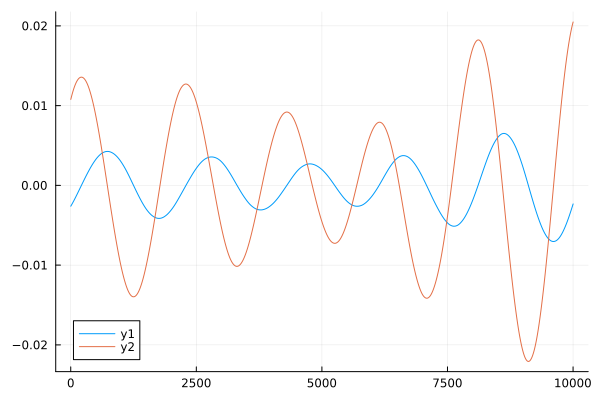

In [25]:
plot(z[1:2:end])
plot!(z[2:2:end])

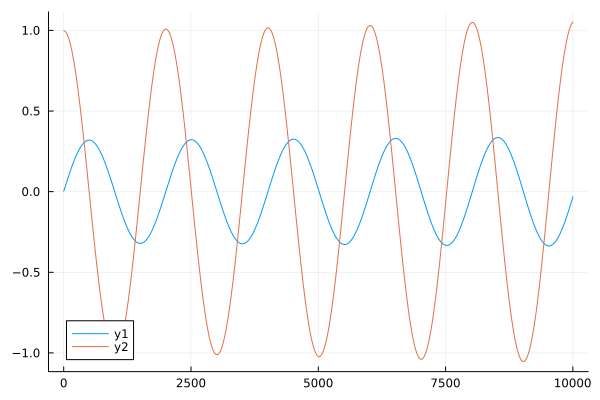

In [26]:
plot(x_smooth[:, 1])
plot!(x_smooth[:, 2])

In [12]:
# need to use previously aquired pendulum data for comparison
pendulum_data = CSV.read("/Users/ryansenne/Documents/GitHub/SSM/notebooks/pendulum_data_1.csv", DataFrame)

# convert x_noisy columns to matrix for use 
x_noisy =  Matrix(pendulum_data[:, 3:4])

# now create a Kalman Filter where we want to learn the parameters
A = [0.1 0.2; 0.3 0.4]
H = [0.5 0.5; 0.5 0.5]
Q = 0.1 * I(2)
R = 1.0 * I(2)
p0 = 1.0 * I(2)
x0 = [0.0, 0.0]

# kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))
kf_unknown = LDS(A, H, nothing, Q, R, x0, p0, nothing, 2, 2, "Gaussian", [true, true, true, true, true, true, true, true, true])
# SSM.pca_init!(kf_unknown, x_noisy)

# SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy), 10)

LDS([0.1 0.2; 0.3 0.4], [0.5 0.5; 0.5 0.5], nothing, [0.1 0.0; 0.0 0.1], [1.0 0.0; 0.0 1.0], [0.0, 0.0], [1 0; 0 1], nothing, 2, 2, "Gaussian", Bool[1, 1, 1, 1, 1, 1, 1, 1, 1])